# Autoencoder feature extraction

In [1]:
from time import time
import scipy.io
from utils import *

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Input, Convolution2D, LocallyConnected2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

plt.rcParams.update({'font.size': 11})
plt.rcParams['figure.constrained_layout.use'] = True

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

SystemError: GPU device not found

In [3]:
mat_contents = scipy.io.loadmat('../data/allFaces.mat')
faces = mat_contents['faces']
m = int(mat_contents['m'])
n = int(mat_contents['n'])
nfaces = np.ndarray.flatten(mat_contents['nfaces'])

allFaces = faces.T # Data usual format of sample rows and feature columns
y = np.zeros((faces.shape[1], 1)) # Creating labels
M = allFaces.reshape(allFaces.shape[0], m, n)
dataset = preprocess_faces(M)

j = 0
classes = list(range(len(nfaces)))
for i in nfaces:
  y[j:j+i] = classes.pop(0)
  j = j + i

## Facebook DeepFace model
Let's first build the model in keras

In [6]:
model = Sequential()
model.add(Convolution2D(32, (11, 11), activation='relu', name='C1', input_shape=(152, 152, 3)))
model.add(MaxPooling2D(pool_size=3, strides=2, padding='same', name='M2'))
model.add(Convolution2D(16, (9, 9), activation='relu', name='C3'))
model.add(LocallyConnected2D(16, (9, 9), activation='relu', name='L4'))
model.add(LocallyConnected2D(16, (7, 7), strides=2, activation='relu', name='L5') )
model.add(LocallyConnected2D(16, (5, 5), activation='relu', name='L6'))
model.add(Flatten(name='F0'))
model.add(Dense(4096, activation='relu', name='F7'))
model.add(Dropout(rate=0.5, name='D0'))
model.add(Dense(8631, activation='softmax', name='F8'))

model.summary()

encoder = Model(inputs=model.layers[0].input, outputs=model.layers[-3].output)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
C1 (Conv2D)                  (None, 142, 142, 32)      11648     
_________________________________________________________________
M2 (MaxPooling2D)            (None, 71, 71, 32)        0         
_________________________________________________________________
C3 (Conv2D)                  (None, 63, 63, 16)        41488     
_________________________________________________________________
L4 (LocallyConnected2D)      (None, 55, 55, 16)        62774800  
_________________________________________________________________
L5 (LocallyConnected2D)      (None, 25, 25, 16)        7850000   
_________________________________________________________________
L6 (LocallyConnected2D)      (None, 21, 21, 16)        2829456   
_________________________________________________________________
F0 (Flatten)                 (None, 7056)             

### Get and load weights from [here](https://github.com/swghosh/DeepFace)

In [32]:
weights = get_weights()
model.load_weights(weights)

## Extract features from faces

Feature generation of face library


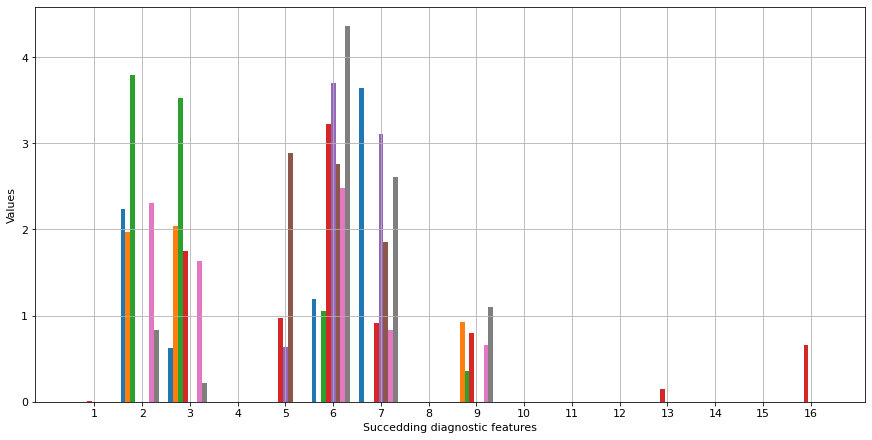

In [34]:
print("Feature generation of face library")
t0 = time()
person = 0
subset = dataset[sum(nfaces[:person]): sum(nfaces[:(person+1)])]
subset = encoder.predict(subset/255)
print("done in %0.3fs" % (time() - t0)
plot_features(subset[:8, :16])

In [35]:
def l2_normalize(x):
    return x / np.sqrt(np.sum(np.multiply(x, x)))
 
def findEuclideanDistance(source_representation, test_representation):
    euclidean_distance = source_representation - test_representation
    euclidean_distance = np.sum(np.multiply(euclidean_distance, euclidean_distance))
    euclidean_distance = np.sqrt(euclidean_distance)
    return euclidean_distance

1  and  2


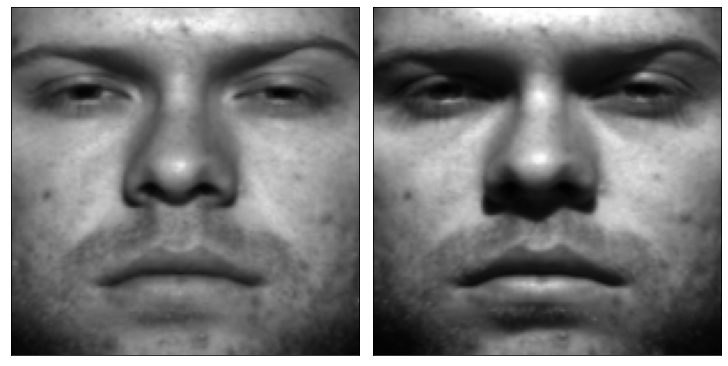

Euclidean L2 distance:  0.70014286
Actual:  True - Predicted:  False
----------------------------------------------


In [36]:
img1_path = 1
img2_path = 2
target = True

print(img1_path, " and ", img2_path)

img1 = dataset[img1_path]/255
img2 = dataset[img2_path]/255

fig = plt.figure()
fig.add_subplot(1,2, 1)
plt.imshow(img1)
plt.xticks([]); plt.yticks([])
fig.add_subplot(1,2, 2)
plt.imshow(img2)
plt.xticks([]); plt.yticks([])
plt.show(block=True)

img1_embedding = encoder.predict(np.expand_dims(img1, axis=0)) #this has 4096 dimensional output
img2_embedding = encoder.predict(np.expand_dims(img2, axis=0)) #this has 4096 dimensional output


euclidean_distance = findEuclideanDistance(img1_embedding, img2_embedding)
euclidean_l2_distance = findEuclideanDistance(l2_normalize(img1_embedding), l2_normalize(img2_embedding))

print("Euclidean L2 distance: ", euclidean_l2_distance)
print("Actual: ", target, end = '')

if euclidean_l2_distance <= 0.55:
    verified = True
else:
    verified = False
    
print(" - Predicted: ", verified)

print("----------------------------------------------")

# Facial recognition with NN
### Train a softmax classification layer

In [58]:
input_layer = Input(shape=4096)
output = Dense(units=len(nfaces), activation='softmax')(input_layer)
clf = Model(input_layer, output)
clf.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
clf.summary()
accuracy = []

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 4096)]            0         
_________________________________________________________________
dense_2 (Dense)              (None, 38)                155686    
Total params: 155,686
Trainable params: 155,686
Non-trainable params: 0
_________________________________________________________________


In [80]:
# Split into a training and testing set
X_tv, X_test, y_tv, y_test = train_test_split(dataset, y, test_size=0.4, shuffle=True, stratify=y)

y_tv = tf.keras.utils.to_categorical(y_tv)
X_tv = encoder.predict(X_tv/255)
hist = clf.fit(X_tv, y_tv, batch_size=64, epochs=50, validation_split=0.1)

Epoch 1/50
21/21 [==============================] - 0s 5ms/step - loss: 0.0473 - accuracy: 0.9923 - val_loss: 0.0599 - val_accuracy: 0.9862
Epoch 2/50
21/21 [==============================] - 0s 3ms/step - loss: 0.0239 - accuracy: 0.9969 - val_loss: 0.0598 - val_accuracy: 0.9862
Epoch 3/50
21/21 [==============================] - 0s 3ms/step - loss: 0.0073 - accuracy: 0.9977 - val_loss: 0.0340 - val_accuracy: 0.9931
Epoch 4/50
21/21 [==============================] - 0s 3ms/step - loss: 0.0083 - accuracy: 0.9985 - val_loss: 0.0394 - val_accuracy: 0.9931
Epoch 5/50
21/21 [==============================] - 0s 4ms/step - loss: 0.0041 - accuracy: 0.9985 - val_loss: 0.0353 - val_accuracy: 0.9931
Epoch 6/50
21/21 [==============================] - 0s 3ms/step - loss: 0.0038 - accuracy: 0.9985 - val_loss: 0.0370 - val_accuracy: 0.9931
Epoch 7/50
21/21 [==============================] - 0s 3ms/step - loss: 0.0038 - accuracy: 0.9992 - val_loss: 0.0529 - val_accuracy: 0.9931
Epoch 8/50
21/21 [==

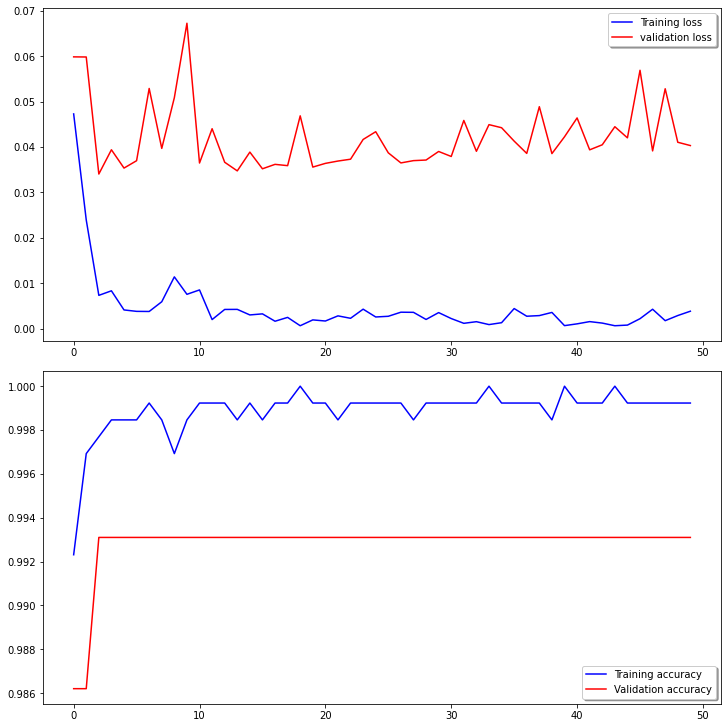

In [81]:
# Plot the loss and accuracy curves for training and validation 

fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['loss'], color='b', label="Training loss")
ax[0].plot(hist.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

### Quantitative evaluation of the model quality on the test set

In [82]:
print("Predicting people's names on the test set")
t0 = time()
X_test_enc = encoder.predict(X_test/255)
y_pred = clf.predict(X_test_enc)
y_pred = np.argmax(y_pred, axis=1)
print("done in %0.3fs" % (time() - t0))

target_names = [f"Person{n}" for n in range(1,39)]

print(classification_report(y_test, y_pred, target_names=target_names))

# Plot confusion matrix
confusion_mtx = confusion_matrix(y_test, y_pred)
print(confusion_matrix(y_test, y_pred))

Predicting people's names on the test set
done in 2.284s
              precision    recall  f1-score   support

     Person1       1.00      1.00      1.00        26
     Person2       0.96      0.92      0.94        25
     Person3       1.00      1.00      1.00        26
     Person4       1.00      1.00      1.00        26
     Person5       1.00      1.00      1.00        25
     Person6       1.00      1.00      1.00        25
     Person7       1.00      1.00      1.00        26
     Person8       0.93      1.00      0.96        25
     Person9       1.00      0.96      0.98        26
    Person10       1.00      1.00      1.00        26
    Person11       1.00      1.00      1.00        24
    Person12       1.00      1.00      1.00        23
    Person13       1.00      1.00      1.00        24
    Person14       1.00      1.00      1.00        25
    Person15       1.00      1.00      1.00        25
    Person16       1.00      1.00      1.00        25
    Person17       1.00 

### Qualitative evaluation of the predictions using matplotlib

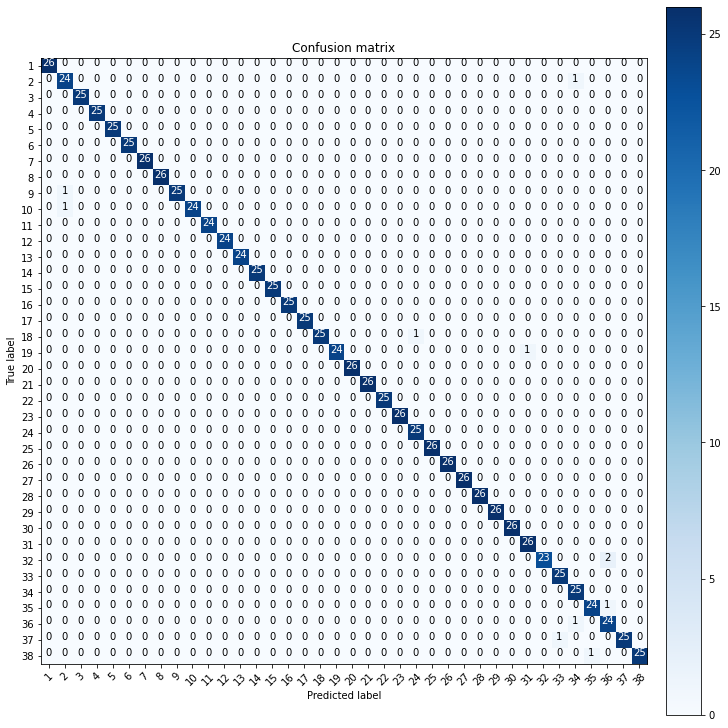

In [76]:
plt.rcParams.update({'font.size': 10})
plt.rcParams['figure.figsize'] = [10, 10]
plot_confusion_matrix(confusion_mtx, range(1,39))
# plt.savefig('Paper/figures/EncoderConfusion.pdf')

/content/drive/My Drive/TUM/EI/7-SS20/PyData/Report/utils.py:38: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)


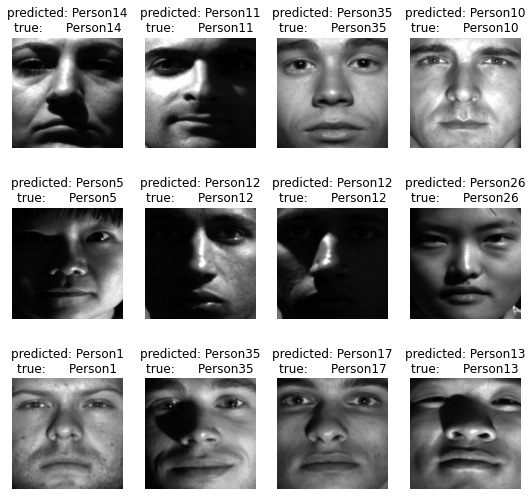

In [83]:
# plot the result of the prediction on a portion of the test set

prediction_titles = [title(y_pred, y_test, target_names, i) for i in range(y_pred.shape[0])]
plot_gallery(X_test, prediction_titles, m, n, rgb=True)
# plt.savefig("Paper/figures/EncoderGallery.pdf")

In [78]:
accuracy.append(accuracy_score(y_test, y_pred))

In [79]:
accuracy

[0.9491701244813278, 0.9823651452282157, 0.9885892116182573]